# Arné's KnetGraphing Notebook, a Presentation and Tutorial 📓🧪
<!-- Title above -->
This notebook displays some of the interesting graphing examples I thought of throughout my first few days of learning Neo4j, Cypher query language, KnetMiner's database and Jupyter notebooks. I have written it up with extensive notes for helping beginners find their footing.

Detailed explinations are provided both within (1) the Markdown step overviews and (2) code-block comments.

## Step One - Initial Setup
For a start, we do six imports, (1) for display functionality (mainly used for troubleshooting in our case), (2) neo4j graphing, (3,4) seaborn and matplotlib for data visualization, (5) Pandas for data manipulation and (6) NetworkX for displaying network graphs. 

<br>
Thereafter, we initialise the GraphDatabase, linking it to the KnetMiner Poaceae (grasses: a set of gramineae, including wheat) database and create a short (*but very handy*), method for parsing different cypher queries, depending on what graph we want to draw in the later steps.
<br><br>
Please note: to run any of the figures, you require the initial setup code block.

In [2]:
# Imports
from IPython.display import display
from neo4j import GraphDatabase
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# Setting up the Neo4J driver link, linking to KnetMiner Poaceae      
driver = GraphDatabase.driver("bolt://knetminer-neo4j.cyverseuk.org:7687") 
# Making the above our active session
session = driver.session()

# Creating a method for easier querying from anywhere within the code
def cypherRunner(cypher):
      return session.run(cypher)


## Step Two - Graph One (Bar Plot)
#### My first graph displays the 20 most cited traits within the Poaceae dataset.
We begin by writing a cypher query. This was initially done on the online browser, for easier data visualisation and query-building (*http://knetminer-wheat.cyverseuk.org:7474/browser/ No authentication needed.*).
<br>
Thereafter, we store the result of the ran query in python and create an empty dataframe (which is currently still a list)
<br><br>
Next, we iterate through all records outputted by our query and create new variables for storing (in strings) t.prefname (Trait Name) and the queried countCol (Citation Count). We then append these into our 2d list.
<br>
Hereafter we setup the headers for the df and turn the 2d list df into a true df with pandas.
<br>
We print the df head.
<br><br>
In the final section we plot the graph by pointing sns (Seaborn) to the data and telling it which headings to use for the x and y col.
<br>
We then make further modifications to allow the graph to appear as we want it to. We rotate our labels by 90deg, add a title, margins and tight layout.
<br><br><br>
Finally, we save the figure to our working directory. ✨


           Trait Name  Citation Count
0  disease resistance             940
1    oxidative stress             668
2      salt tolerance             507
3   drought tolerance             486
4        plant height             391


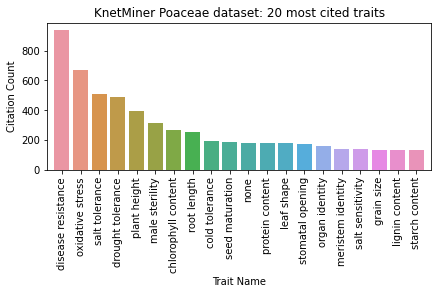

In [3]:
# Cypher query, matching genes with cooccurrence with Traits and returning unique (distinct) trait names, as well as counting the amounts of each distinct trait and storing it in countCol. The output is ordered in desc order, and since we want only the top 20 we cap it at 20 with Limit 20.
cypher = """
MATCH p=(g:Gene)-[r:cooc_wi]->(t:Trait) 
RETURN DISTINCT t.prefName, COUNT ( t.prefName) AS countCol
ORDER BY countCol DESC
LIMIT 20
"""
# Storing the result of running the cypher query through our cypherRunner method (as made above) 
result = cypherRunner(cypher)

# Creating our "dataframe" ("df") - currently a list though
dframe = []

# For every record in the result we're pulling from the KnetMiner DB
for record in result:
  # Setting up variables in Python, assigning individual records from the DB
  tprefName = record [ "t.prefName"]
  countCol = record [ "countCol"]
  # Appending the two records into our "df"
  dframe.append ( [tprefName, countCol] )

# Setting the headers within the "df"
headers = [ "Trait Name", "Citation Count" ]
# Turning the list into a real dataframe (df)
dframe = pd.DataFrame ( dframe, columns = headers )
# Printing the head (5 rows) of the df to console
print (dframe.head())

# Beginning graphing a bar plot: setting x to Trait Name, y to Count and the dataset to use to our df
g = sns.barplot(x="Trait Name", y="Citation Count", data=dframe)
# Rotating our labels by 90 degrees to keep them legible
g.set_xticklabels(g.get_xticklabels(),rotation=90)
# Setting up the plot title
g.set(title = "KnetMiner Poaceae dataset: 20 most cited traits")
# Adding a margin with tight layout to avoid graph text escaping borders
g.margins(x=0.02)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# Saving the figure to working dir
g.figure.savefig("20MostCitedTraits_Graph01")

## Step Three - Graph Two
#### My second graph displays the top 50 Gene-cooccurrence->Traits in a spring layout multigraph, using the Poaceae dataset. Line thickness displays the citation count for trait-gene co-occurrence relationship within datamined KnetMiner DB.

We begin by writing our next cypher query. This was also initially done on the online browser, for easier data visualisation and query-building (*http://knetminer-wheat.cyverseuk.org:7474/browser/ No authentication needed.*).
<br>
Thereafter, we store the result of the ran query in a python variable.
<br><br>
Now we initialize the creation of a DiGraph and iterate through all records outputted by our query. Creating new variables for storing (in strings) t.prefname (Trait Name), g.prefName (Gene Name) and recordWeight (Citation Count).
<br>
Hereafter we create nodes and edges (the lines between nodes) showing gene/trait relation and line weight (line thickness). We divide recordWeight by 60 and set it to adjustedWeight (used later for avoiding making the lines incredibly thick).
<br>
We make a list of weights for modifying the line thickness.
<br><br>
Finally we get to graphing: we set the layout to Spring, increase the size by 4X, add titles and modify colors, node sizes, edge colors and fonts. 
<br><br><br>
All that's left to do is to draw edge labels, using draw_networkx_edge_labels, and saving the figure with tight formation to minimise excessive white space. We add plt.show just in case the notebook doesn't auto-display the image. ✨



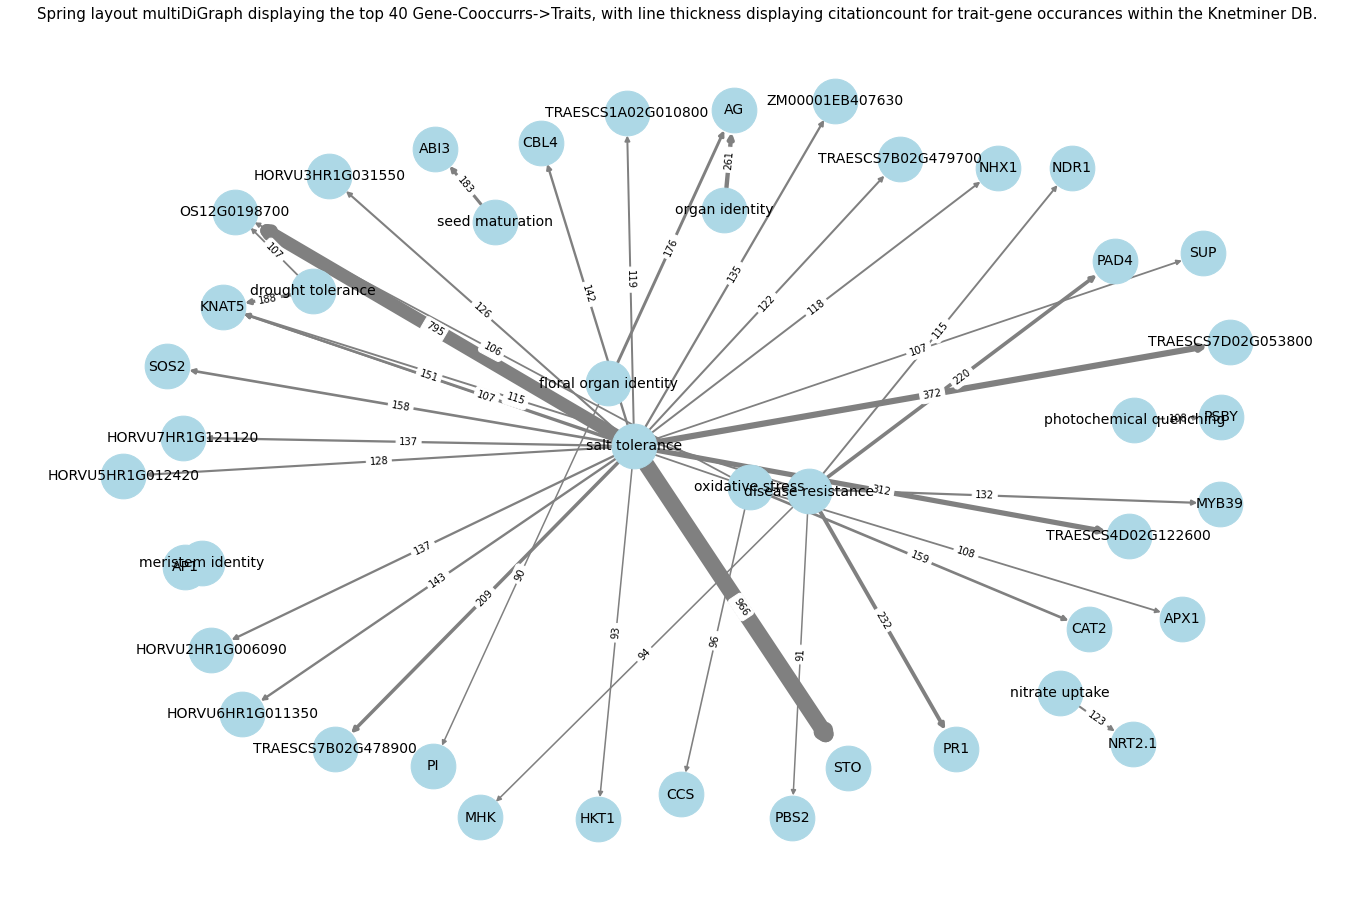

In [4]:
# Cypher multiline query matching genes with cooccurrence with Traits and returning citation number (in int) as CitationCount, as well as t.prefName (trait name) and g.prefName (gene name). We then order by the amount of citations in descending order and limit our results to 40
cypher = """
MATCH p=(g:Gene)-[r:cooc_wi]->(t:Trait)
RETURN toInteger(r.CoCitNum) AS CitationCount, t.prefName, g.prefName 
ORDER BY CitationCount DESC
LIMIT 40
"""
# Storing the result of running the cypher query through our cypherRunner method (as per previous, and as made above) 
result = cypherRunner(cypher)

# Initializing the creation of a DiGraph
G = nx.DiGraph()
# For every record in the result we're pulling from the KnetMiner DB
for record in result:
  # Setting up variables in Python, assigning individual records from the DB
  tprefName = record [ "t.prefName" ]
  gprefName = record [ "g.prefName" ]
  recordWeight = record['CitationCount']

  # Creating nodes and edges (lines) that shows the gene/trait relation, with line weight (thickness) being according to citation count of articles mentioning the trait, in relation to the gene.
  G.add_node ( tprefName )
  G.add_node ( gprefName )
  G.add_edge ( tprefName, gprefName, weight = recordWeight, adjustedWeight = recordWeight / 60)

# Making a list of weights for use with modifying the line thickness
weights = list(nx.get_edge_attributes(G,'adjustedWeight').values())
  
# Setting the graph to a spring layout
pos = nx.spring_layout (G)
# Fetching the figure size and multiplying it. Change the 4 to increase or decrease the size, in this case.
figsz = plt.gcf().get_size_inches()
plt.gcf().set_size_inches ( figsz * 4 ) 
# Adding a title
plt.title("Spring layout multiDiGraph displaying the top 40 Gene-Cooccurrs->Traits, with line thickness displaying citationcount for trait-gene occurances within the Knetminer DB.", fontsize=15)
# Coloring the graph, setting labels, node sizes, etc.
nx.draw (G, pos, with_labels = True, node_color = '#ADD8E6', node_size = 2000, \
         edge_color = 'grey', font_color = "black", \
         font_size = 14, width = weights)
# Adding individual labels to the labels, containing the citation count
edge_labels = { (u,v): d['weight'] for u,v,d in G.edges(data=True) }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Saving out the figure as tight, to try minimise white space
plt.savefig("SpringLayoutDiGraph.png", bbox_inches='tight')

# Double-checking that the notebook will show the figure.
plt.show()

## Step Four - Graph Three (Work in progress)
#### My third graph displays a wordcloud of words recently used in evidence (Gene-cooccurrence->Traits) data mined by KnetMiner. It is still a work in progress.

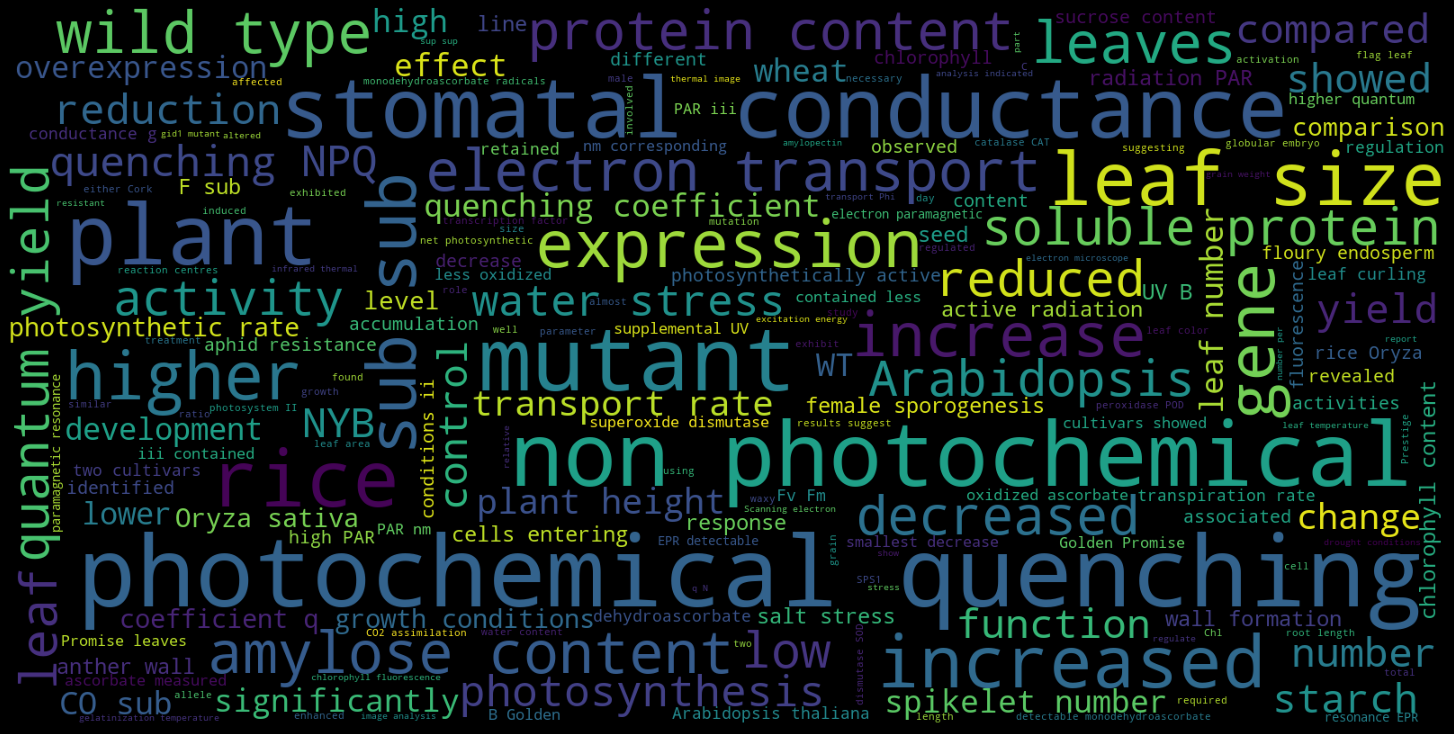

<Figure size 432x288 with 0 Axes>

In [19]:
cypher = """
MATCH p=(g:Gene)-[r:cooc_wi]->(t:Trait) RETURN r.EVIDENCE LIMIT 1000
"""

result = cypherRunner(cypher)

listOfWords = []

#For every record in the result we're pulling from the DB
for record in result:
  #setting up variables in Python, assigning individual records from the DB
  evidence = record [ "r.EVIDENCE" ]
  listOfWords.append(evidence)

#print (listOfWords)
from wordcloud import WordCloud

# Create the wordcloud object
wordcloud = WordCloud(width=1600, height=800).generate(str(listOfWords))

# Display the generated image:

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

plt.savefig("WIP_WordCloud.png", bbox_inches='tight')
plt.show()